# Machine learning with the Open Data Cube <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ls8_nbart_geomedian_annual](https://explorer.sandbox.dea.ga.gov.au/ls8_nbart_geomedian_annual)
* **Special requirements:** A shapefile of labelled data in shapefile format is required to use this notebook.
An example dataset is provided.
* **Prerequisites:** A basic understanding of supervised learning techniques is required. 
[Introduction to statistical learning](https://doi.org/10.1007/978-1-4614-7138-7) is a useful resource to begin with - it can be downloaded for free [here](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf). 
The [Scikit-learn](https://scikit-learn.org/stable/supervised_learning.html) documentation provides information on the available models and their parameters.


## Description

This notebook demonstrates a potential workflow using functions from the [dea_classificationtools](../Scripts/dea_classificationtools.py) script to implement a supervised learning landcover classifier within the [ODC (Open Data Cube)](https://www.opendatacube.org/) framework. 

For larger model training and prediction implementations this notebook can be adapted into a Python file and run in a distributed fashion.

This example predicts a single class of cultivated / agricultural areas.
The notebook demonstrates how to:

1. Extract the desired ODC data for each labelled area (this becomes our training dataset).
2. Train a simple decision tree model and adjust parameters. 
3. Predict landcover using trained model on new data.
4. Evaluate the output of the classification using quantitative metrics and qualitative tools.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import shapely
import rasterio
import datacube
import matplotlib
import pydotplus
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from io import StringIO
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from IPython.display import Image
from datacube.utils import geometry
from datacube.helpers import write_geotiff

sys.path.append('../../../Scripts')
from dea_plotting import map_shapefile
from dea_classificationtools import predict_xr
from dea_classificationtools import get_training_data_for_shp

### Connect to the datacube

Connect to the datacube so we can access DEA data.

In [2]:
dc = datacube.Datacube(app='Machine_learning_with_ODC')

### Analysis parameters
* `path`: The path to the input shapefile
* `field`: This is the name of column in your shapefile attribute table that contains the class labels
* `product`: The name of the product to extract. This method works on DEA Landsat Collection 3 ARD Landsat data and annual geomedian composites ([ls8_nbart_geomedian_annual](https://explorer.sandbox.dea.ga.gov.au/ls8_nbart_geomedian_annual)
 is a good start)
* `year`: The year you wish to extract data for, typically the same year the labels were created
* `feature_stats`: This is an option to calculate the mean of the values within the feature. 
It is useful for reducing noise and simplifying the training data

In [6]:
path = '../../../Supplementary_data/Machine_learning_with_ODC/example_training_data.shp'
field = 'classnum'
product = 'ls8_nbart_geomedian_annual'
year = 2016
feature_stats = 'mean'

### Preview input data and study area

We can load and preview our input data shapefile using `geopandas`.
The shapefile should contain a column with class labels (e.g. `classnum` below).
These labels will be used to train our model.

In [7]:
# Load input data shapefile
input_data = gpd.read_file(path)

# Plot first five rows
input_data.head()

,classnum,geometry
0,112,"POLYGON ((-1521875.000 -3801925.000, -1521900...."
1,111,"POLYGON ((-1557925.000 -3801125.000, -1557950...."
2,111,"POLYGON ((-1555325.000 -3800000.000, -1555200...."
3,111,"POLYGON ((-1552925.000 -3800950.000, -1552925...."
4,111,"POLYGON ((-1545475.000 -3800000.000, -1544325...."


The data can also be explored using the interactive map below.
Hover over each individual feature to see a print-out of its unique class label number above the map.

In [8]:
# Plot training data in an interactive map
map_shapefile(input_data, attribute=field)

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


Label(value='')

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/…

## Extract training data using a shapefile

To train our model, we need to obtain satellite data that corresponds with the labelled input data locations above. 
The function below takes our shapefile containing class labels and extracts the specified product within these areas into a single array.

> **The following cell can take several minutes to run.** The class labels will be contained in the first column of the output array.

In [9]:
# Empty list which we will populate with data
out = []

# Call the extraction function
column_names = get_training_data_for_shp(path=path, 
                                         out=out,
                                         product=product,
                                         time=(f'{year}-01-01',
                                               f'{year}-12-31'),
                                         crs='EPSG:3577', 
                                         field=field,
                                         calc_indices=None,
                                         feature_stats=feature_stats)

# Stack the extracted training data for each feature into a single array
model_input = np.vstack(out)
print(f'\nOutput training data has shape {model_input.shape}')

Loading data...
Rasterizing features and extracting data...
 Feature 0217/0217
Output training data has shape (217, 7)


## Preprocessing

`scitkit-learn` models cannot accept training data with `NaNs` ("not a number"). 
This preprocessing step removes any potential rows in the training array with `NaNs`.

In [10]:
# Remove any potential nans
model_input = model_input[~np.isnan(model_input).any(axis=1)]
print("Cleaned input shape:", model_input.shape)

Cleaned input shape: (217, 7)


Our training data has multiple classes in it.
However, we are only trying to predict one class (i.e. class label 111, _Cultivated Terrestrial Vegetated_) with this model. 
We therefore remove other classes from our training data by setting the label value for all other classes to 0.

These entries provide counter-examples to help the model distinguish the landcover classes from each other.

In [11]:
# Modify the input training data for single class labels
model_input[:,0] = np.where(model_input[:,0] == 111, 1, 0)

So that we can access the accuracy of our classification, we split our data into training and testing data. 
80% is used for training with 20% held back for testing.
When splitting our data, we stratify the training data by the distributions of class membership.
This sampling method leads to a similar distribution of class membership in the training data.

In [12]:
# Split into training and testing data
model_train, model_test = model_selection.train_test_split(model_input, 
                                                           stratify=model_input[:, 0],
                                                           train_size=0.8, 
                                                           random_state=0)
print("Train shape:", model_train.shape)
print("Test shape:", model_test.shape)

Train shape: (173, 7)
Test shape: (44, 7)


## Model preparation

This section automatically creates a list of varaible names and their respective indices for each of the training data variables.

> **Note:** To use a custom subset of the satellite bands loaded above to train our data, you can replace `column_names[1:]` with a list of selected band names (e.g. `['red', 'green', 'blue']`)

In [13]:
# Select the variables we want to use to train our model
model_variables = column_names[1:]

# Extract relevant indices from the processed shapefile
model_col_indices = [column_names.index(var_name) for var_name in model_variables]

A **decision tree model** is chosen as it is one of the simplest supervised machine learning models we can implement. 

Its strengths are its explainability and cheap computational cost.

Parameter tuning can be conducted in the model initialisation below - details on how the different parameters will affect the model are [here](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use).

In [14]:
# Initialise model
model = tree.DecisionTreeClassifier()

## Train model

The model is fitted / trained using the prepared training data. 
The fitting process uses the decision tree approach to create a generalised representation of reality based on the training data. 
This fitted / trained model can then be used to predict which class new data belongs to.

In [15]:
# Train model
model.fit(model_train[:, model_col_indices], model_train[:, 0])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## Analyse results

### Feature importance

The decision tree classifier allows us to inspect the feature importance of each input variable.
Feature importance represents the relative contribution of each variable in predicting the desired landcover class. 
When summed, the importance of all variables should add up to 1.0.

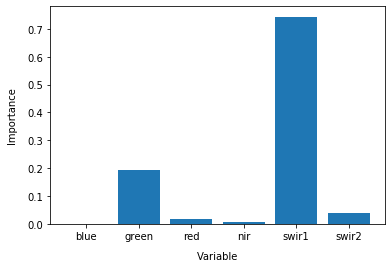

In [16]:
# This shows the feature importance of the input features for predicting the class labels provided
plt.bar(x=model_variables, height=model.feature_importances_)
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Variable', labelpad=10);

This decision tree representation visualises the trained model. 
Here we can see that the model decides which landcover class to assign based on the value of the important variables in the plot above.

The **gini** value shown in the tree represents the decrease in node impurity.
This can also be understood as how heterogeneous the labels are (small values indicating better results). 
This metric is used by the decision tree to determine how to split the data into smaller groups.

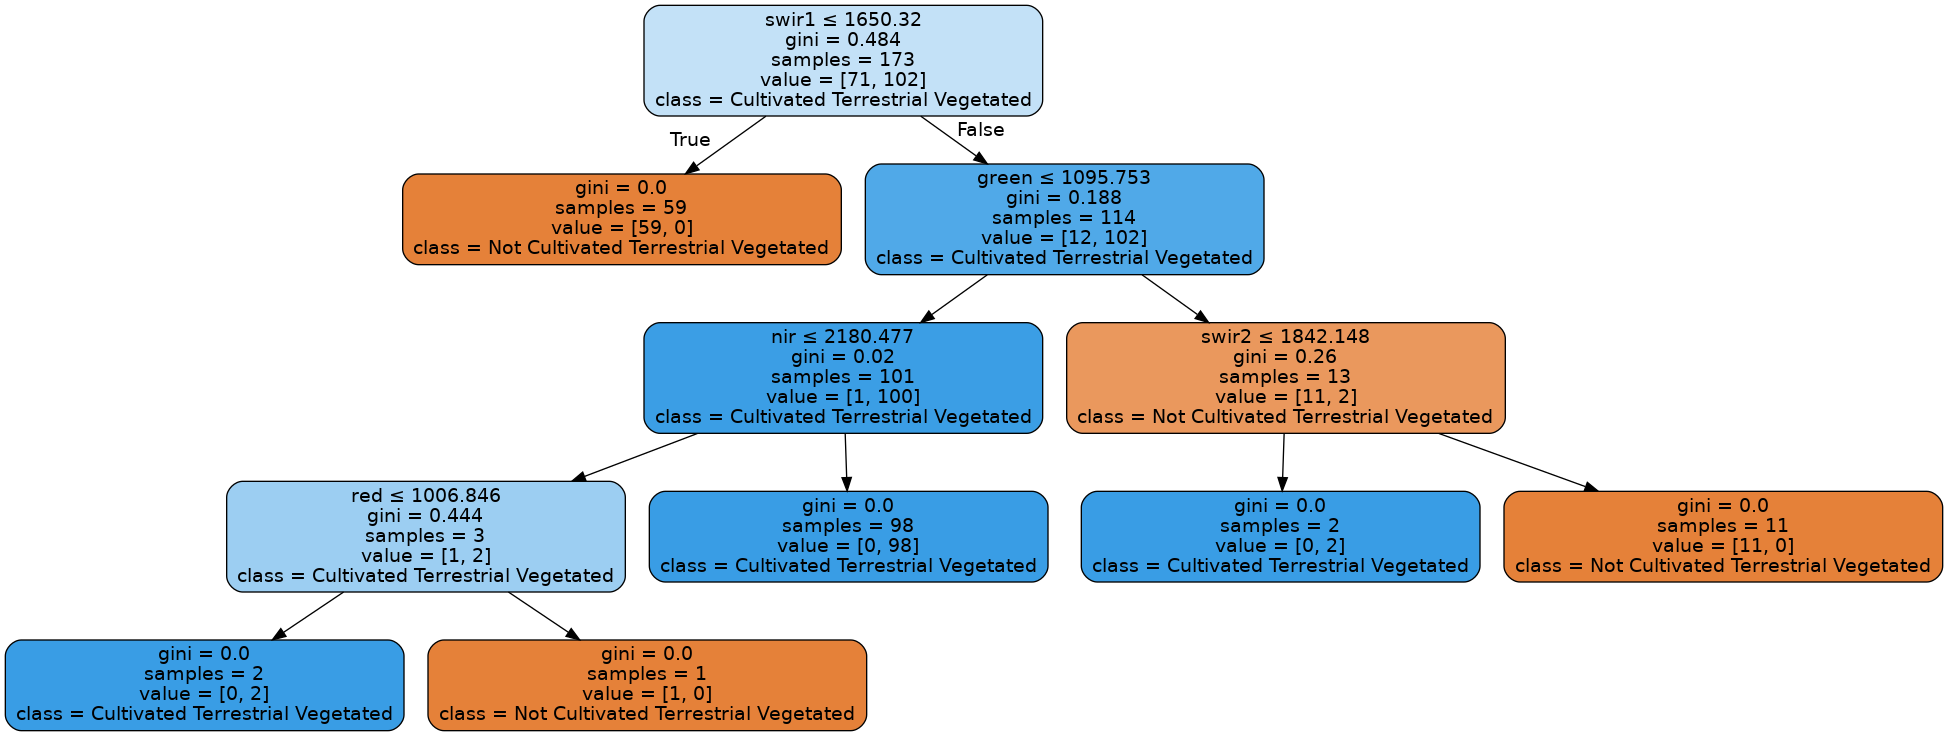

In [17]:
# Prepare a dictionary of class names
class_names = {1: 'Cultivated Terrestrial Vegetated',
               0: 'Not Cultivated Terrestrial Vegetated'}

# Get list of unique classes in model
class_codes = np.unique(model_train[:, 0])
class_names_in_model = [class_names[k] for k in class_codes]

# Plot decision tree
dot_data = StringIO()
tree.export_graphviz(model, 
                     out_file=dot_data, 
                     feature_names=model_variables, 
                     class_names=class_names_in_model,
                     filled=True, 
                     rounded=True,
                     special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

### Accuracy

We can use the 20% sample of test data we partitioned earlier to test the accuracy of the trained model on this new, "unseen" data.

An accuracy value of 1.0 indicates that the model was able to correctly predict 100% of the classes in the test data.

In [18]:
predictions = model.predict(model_test[:, model_col_indices])
accuracy_score(predictions, model_test[:, 0])

0.9772727272727273

## Prediction

Now that we have a trained model, we can load new data and use the `predict_xr` function to predict landcover classes. 

The trained model can technically be used to classify any dataset or product with the same bands as the data originally used to train the data.
However, it is typically highly advisable to classify data from the same product that the data was originally trained on (e.g. `'ls8_nbart_geomedian_annual'` below).


In [19]:
# Get extent from input shapefile 
xmin, ymin, xmax, ymax = input_data.unary_union.bounds

# Set up the query parameters
query = {'time': (f'{year}-01-01', f'{year}-12-31'),
         'x': (xmin, xmax),
         'y': (ymin, ymax),
         'crs': 'EPSG:3577',
         'resolution': (-25, 25)}

# Load new input data
geomedian_data = dc.load(product='ls8_nbart_geomedian_annual', 
                         group_by='solar_day', 
                         **query)

Once the data has been loaded, we can classify it using `predict_xr`:

In [20]:
# Predict landcover using the trained model
predicted = predict_xr(model, geomedian_data, progress=True)
predicted

<xarray.DataArray (time: 1, y: 2053, x: 2365)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01
  * y        (y) float64 -3.8e+06 -3.8e+06 -3.8e+06 ... -3.851e+06 -3.851e+06
  * x        (x) float64 -1.559e+06 -1.559e+06 -1.559e+06 ... -1.5e+06 -1.5e+06

## Plotting

To qualitatively evaluate how well the classification performed, we can plot the classifed/predicted data next to our input satellite imagery.

> **Note:** The output below is unlikely to be optimal the first time the classification is run.
The model training process is one of experimentation and assumption checking that occurs in an iterative cycle - you may need to revisit the steps above and make changes to model parameters or input training data until you achieve a satisfactory result.

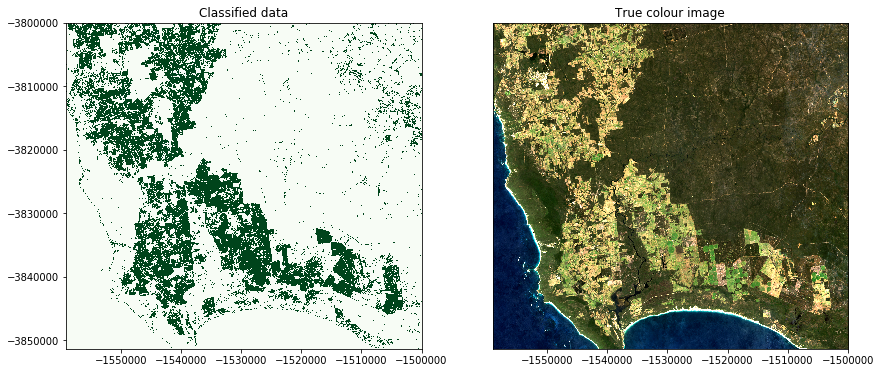

In [21]:
# Set up plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot classified image
predicted.plot(ax=axes[0], 
               cmap='Greens', 
               add_labels=False, 
               add_colorbar=False)

# Plot true colour image
(geomedian_data[['red', 'green', 'blue']]
 .squeeze('time')
 .to_array()
 .plot.imshow(ax=axes[1], robust=True, add_labels=False))

# Remove axis on right plot
axes[1].get_yaxis().set_visible(False)

# Add plot titles
axes[0].set_title('Classified data')
axes[1].set_title('True colour image');

In [22]:
# Andrews CRS Reprojection Code

from datacube.utils.geometry import GeoBox, Geometry, CRS
from collections.abc import Mapping
from datacube.virtual.impl import reproject_array, reproject_band, compute_reproject_roi

def reproject(ds, output_crs, output_res=None, resampling=None, dask_chunks=None):
    if isinstance(ds, xr.DataArray):
        return reproject_slice(ds, output_crs, output_res, resampling, dask_chunks)
    
    output_crs = CRS(output_crs)
    
    if output_res is None:
        if output_crs.units[0] not in CRS(ds.crs).units:
            raise ValueError
        else:
            output_res = ds.geobox.resolution

    output_geobox = GeoBox.from_geopolygon(ds.geobox.geographic_extent, resolution=output_res, crs=output_crs)
    
    output_bands = {}
    for band_name, band in ds.items():
        if hasattr(band.data, 'dask') and dask_chunks is None:
            dask_chunks = dict(zip(band.dims, band.data.chunksize))

        if isinstance(resampling, Mapping):
            band_resampling = resampling[band_name] if band_name in resampling else 'nearest'
        else:
            band_resampling = resampling
        output_bands[band_name] = reproject_band(band, output_geobox, resampling=band_resampling, dims=band.dims, dask_chunks=dask_chunks)
    
    return xr.Dataset(output_bands, attrs={'crs': output_crs})


def reproject_da(da, output_crs, output_res=None, resampling=None, dask_chunks=None):
    output_crs = CRS(output_crs)
    
    if output_res is None:
        if output_crs.units[0] not in CRS(da.geobox.crs).units:
            raise ValueError
        else:
            output_res = da.geobox.resolution

    output_geobox = GeoBox.from_geopolygon(da.geobox.geographic_extent, resolution=output_res, crs=output_crs)
    
    if hasattr(da.data, 'dask') and dask_chunks is None:
        dask_chunks = dict(zip(da.dims, da.data.chunksize))
        
    if 'nodata' not in da.attrs:
        da.attrs['nodata'] = np.nan

    output_band = reproject_band(da, output_geobox, resampling=resampling, dims=da.dims, dask_chunks=dask_chunks)
    output_band.attrs['crs'] = output_crs
    return output_band
    
def reproject_slice(da, output_crs, output_res, resampling, dask_chunks):
    bad_dims = [dim for dim, dim_size in da.sizes.items() if dim not in ('x', 'y') and dim_size > 1]
    if bad_dims:
        dim_name = bad_dims[0]
        return xr.concat([reproject_slice(
            da.isel(**{dim_name:i}), output_crs, output_res, resampling, dask_chunks
                   ) for i in range(da[dim_name].size)], dim=dim_name).transpose(*da.dims)
    else:
        return reproject_da(da, output_crs, output_res, resampling, dask_chunks)

In [34]:
# Code to create sidecar and add the map to it

import ipyleaflet
from sidecar import Sidecar
from ipywidgets import IntSlider, widgets as w
import xarray as xr
import odc.algo
import odc.ui

# Create sidecar and map widget
sc = Sidecar(title='Map')

# Create map and add it to sidecar
m = ipyleaflet.Map( center=(-25, 133), zoom=3, scroll_wheel_zoom=True)

# Add Full Screen and Layers Controls
m.add_control(ipyleaflet.FullScreenControl())
m.add_control(ipyleaflet.LayersControl())



# Add the opactity slider
slider = w.FloatSlider(min=0, max=1, value=1,        # Opacity is valid in [0,1] range
                       orientation='vertical',       # Vertical slider is what we want
                       readout=False,                # No need to show exact value
                       layout=w.Layout(width='2em')) # Fine tune display layout: make it thinner
m.add_control(ipyleaflet.WidgetControl(widget=slider))

# Add map to sidecar
with sc:
    display(m)

In [35]:
# Function to colorize a single band

from matplotlib import cm
from matplotlib.colors import Normalize

def colorize(da, cmap='viridis', vmin=None, vmax=None):
    """
    Convert values in single band xarray to colormap values
    Can accept multiple time steps
    da - xarray.DataArray
    cmap - desired colormapping
    vmin / vmax - values for normalisation
    """
    normalized = Normalize(vmin=vmin, vmax=vmax)(da)
    colormapped = cm.get_cmap(cmap)(normalized, bytes=True)
    colormapped_xr = xr.DataArray(data=colormapped, 
                                  coords = da.coords, 
                                  dims=da.dims+('band',),
                                  attrs=da.attrs
                                 )
    # Mask out the no data
    colormapped_xr[...,3] = np.isfinite(da) * 255
    return colormapped_xr

In [36]:
# Code to add the geomedian data to the map

# Re-project
geomedian_data_reprojected_data = reproject(geomedian_data, 'epsg:3857', resampling='nearest')
# Mask out invalid data
geomedian_data_reprojected_data = datacube.storage.masking.mask_invalid_data(geomedian_data_reprojected_data)
# Create the image, requires a clamp due to high values
image = odc.ui.mk_image_overlay(geomedian_data_reprojected_data, clamp=(3000), layer_name='GeoMedian')
# Work out the required map zoom based on the bounding box
bounding_box = geomedian_data_reprojected_data.geobox.geographic_extent.boundingbox
zoom = odc.ui.zoom_from_bbox(bounding_box)
# Update the map zoom
m.zoom = zoom
# Center map on new image
m.center = (bounding_box[1], bounding_box[0])
# Add the opacity slider to the new image
w.jslink((slider, 'value'),         
         (image, 'opacity') )
m.add_layer(image)

In [26]:
# Add the predictions to the map

# Re-project
predicted_reprojected_data = reproject(predicted, 'epsg:3857', resampling='nearest')

# Colorize
cm_da2 = colorize(predicted_reprojected_data, vmin=0, vmax=1, cmap='Greens')

# Create the image
image2 = odc.ui.mk_image_overlay(cm_da2, layer_name='Predictions')

bounding_box2 = predicted.geobox.geographic_extent.boundingbox
zoom2 = odc.ui.zoom_from_bbox(predicted.geobox.geographic_extent.boundingbox)
# Update the map zoom
m.zoom = zoom2
# Center map on new image
bounding_box2 = predicted.geobox.geographic_extent.boundingbox
m.center = (bounding_box2[1], bounding_box2[0])
# Add the opacity slider to the new image
w.jslink((slider, 'value'),         
         (image2, 'opacity') )
m.add_layer(image2)

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


## Exporting classification
We can now export the predicted landcover out to a GeoTIFF `.tif` file. 
This file can be loaded into GIS software (e.g. QGIS, ArcMap) to be inspected more closely.

In [ ]:
# Write the predicted data out to a GeoTIFF
predicted = predicted.to_dataset(name="predicted")
predicted = predicted.isel(time=0)
predicted.attrs['crs'] = geometry.CRS("EPSG:3577")
write_geotiff('predicted.tif', predicted)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** February 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)